In [15]:
from PipelineResources import * # This is where we have all of the resources that will be used in the project. 

In [16]:
nasdaq = pd.read_pickle('upm_yahoo.pckl')

## Prepare training, validation and test sets

### First Test: Use a CNN Model to predict whether or not the next day will close above 1.5 %. 
The goal behind this exercise is to establish a baseline model and performance. In addition, it is also work out the way the data will be stored. 

In [17]:
number_of_samples = nasdaq.index.size
print(" Sample size is: {}".format(number_of_samples))

 Sample size is: 4755


In [18]:
nasdaq.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'open_change', 'open_change_pct', 'next_day_open_change',
       'next_day_open_change_pct', 'open_change_wrt_close',
       'open_change_wrt_close_pct', 'open_change_wrt_high',
       'open_change_wrt_low', 'open_change_wrt_volume',
       'next_day_open_change_wrt_close', 'next_day_open_change_wrt_close_pct',
       'next_day_open_change_wrt_high', 'next_day_open_change_wrt_low',
       'next_day_open_change_wrt_volume', 'close_change_pct', 'close_change',
       'high_change_pct', 'high_change', 'low_change_pct', 'low_change',
       'volume_change_pct', 'volume_change', 'high_low_range',
       'high_low_range_with_ref_open', 'high_low_range_with_ref_open_pct',
       'high_low_range_with_ref_close', 'high_low_range_with_ref_close_pct',
       'gt_1', 'gt_1.5', 'gt_2.5'],
      dtype='object')

In [19]:
### random_state = 1
x_train, x_val, x_test, y_train, y_val, y_test = get_input_sets(nasdaq, chosen_features, 
                                                                chosen_label, x_test=False,
                                                               number_of_days_per_sample=1)
print(x_train.shape)


number of days per samples: 1
(4751,)
[0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
(4751, 13)
(3563, 13)


### Balance classes

In [20]:
x_val, y_val = decrease_class_rows(x_val, y_val, 
                                   class_number=0, 
                                   percentage_cut=0.90)
x_train, y_train = decrease_class_rows(x_train, y_train, 
                                       class_number=0, 
                                       percentage_cut=0.90)


1075
967
(221,)
(221, 13)
3240
2916
(647,)
(647, 13)


### Setup multi channels and FFT

In [21]:
x_train, x_val, x_test = modify_dataset_channels(x_train, x_val, 
                                                 x_test=False, 
                                                 compute_fft=True, 
                                                 multi_channel=True)

(647, 2, 13)
(221, 2, 13)


In [22]:
class LeNet5(nn.Module):
    def __init__(self, n_channels, n_features, mid_layer_channels=16,
                 C_k_p_s_1=[2, 0, 1], M_k_s_1=[2, 2], C_k_p_s_2=[2, 0, 1],
                 M_k_s_2=[2, 2], p=[0.0, 0.0, 0.0, 0.0, 0.0],
                 add_noise_to_input=False):
        super(LeNet5, self).__init__()
        self.add_noise_to_input = add_noise_to_input
        self.name = 'LetNet5'
        self.conv1d_1 = nn.Conv1d(n_channels, mid_layer_channels,
                                  kernel_size=C_k_p_s_1[0], padding=C_k_p_s_1[1],
                                  stride=C_k_p_s_1[2])
        # self.batch_1 = nn.BatchNorm1d(16)
        self.relu = nn.ReLU()
        self.max_pool_1 = nn.MaxPool1d(kernel_size=M_k_s_1[0],
                                       stride=M_k_s_1[1])
        current_input_size = \
        (1 + (n_features - C_k_p_s_1[0] + 2 * C_k_p_s_1[1]) / C_k_p_s_1[2]) / M_k_s_1[0]
        current_input_size = int(current_input_size)
        self.drop_out_1 = nn.Dropout(p=p[0])
        # bp()
        self.conv1d_2 = nn.Conv1d(mid_layer_channels,
                                  2 * mid_layer_channels, 
                                  kernel_size=C_k_p_s_2[0],
                                  padding=C_k_p_s_2[1],
                                  stride=C_k_p_s_2[2])
        current_input_size = \
        (1 + (current_input_size - C_k_p_s_2[0] + 2 * C_k_p_s_2[1]) / C_k_p_s_2[2]) / M_k_s_1[0]
        current_input_size = int(current_input_size)
        self.drop_out_2 = nn.Dropout(p=p[1])
        self.max_pool_2 = nn.MaxPool1d(kernel_size=M_k_s_2[0],
                                       stride=M_k_s_2[1])
        
        self.fc1 = nn.Linear(2 * mid_layer_channels * current_input_size, 120)
        self.drop_out_3 = nn.Dropout(p=p[2])
        self.fc2 = nn.Linear(120, 84)
        self.drop_out_4 = nn.Dropout(p=p[3])
        self.fc3 = nn.Linear(84, 10)
        self.drop_out_5 = nn.Dropout(p=p[4])
        # self.soft_max = nn.Softmax(dim=1)
        self.fc4 = nn.Linear(10, 2)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # bp()
        x = x.float()
        #if self.add_noise_to_input:
        #    x = add_noise(x)
        #    x = x.float()
        x = self.max_pool_1(self.relu(self.drop_out_1(self.conv1d_1(x))))
        # bp()
        x = self.max_pool_2(self.relu(self.drop_out_2(self.conv1d_2(x))))
        x = x.view(x.shape[0], x.shape[1] * x.shape[2])
        x = self.relu(self.drop_out_3(self.fc1(x)))
        x = self.relu(self.drop_out_4(self.fc2(x)))
        x = self.relu(self.drop_out_5(self.fc3(x)))
        # x = self.sigmoid(self.fc4(x))
        # bp()
        # x = self.soft_max(self.fc4(x))
        # x = self.fc3(x)
        x = self.fc4(x)
        #fc4_output = self.fc4(x)
        #print(fc4_output)
        #x = F.softmax(fc4_output, dim=1)
        return x


In [23]:
class AvgLeNet(nn.Module):
    def __init__(self, n_channels, n_features, mid_layer_channels=16,
                 C_k_p_s_1=[2, 0, 1], M_k_s_1=[2, 2], C_k_p_s_2=[2, 0, 1],
                 M_k_s_2=[2, 2], p=[0.0, 0.0, 0.0, 0.0, 0.0]):
        super(AvgLeNet, self).__init__()
        self.name = 'AvgLeNet'
        self.conv1d_1 = nn.Conv1d(n_channels,
                                  mid_layer_channels,
                                  kernel_size=C_k_p_s_1[0],
                                  padding=C_k_p_s_1[1],
                                  stride=C_k_p_s_1[2])
        # self.batch_1 = nn.BatchNorm1d(16)
        self.relu = nn.ReLU()
        self.max_pool_1 = nn.MaxPool1d(kernel_size=M_k_s_1[0],
                                       stride=M_k_s_1[1])
        current_input_size = \
        (1 + (n_features - C_k_p_s_1[0] + 2 * C_k_p_s_1[1]) / C_k_p_s_1[2]) / M_k_s_1[0]
        current_input_size = int(current_input_size)
        self.drop_out_1 = nn.Dropout(p=p[0])
        # bp()
        self.conv1d_2 = nn.Conv1d(mid_layer_channels,
                                  2 * mid_layer_channels, kernel_size=C_k_p_s_2[0],
                                  padding=C_k_p_s_2[1],
                                  stride=C_k_p_s_2[2])
        current_input_size = \
        (1 + (current_input_size - C_k_p_s_2[0] + 2 * C_k_p_s_2[1]) / C_k_p_s_2[2]) / M_k_s_1[0]
        current_input_size = int(current_input_size)
        self.drop_out_2 = nn.Dropout(p=p[1])
        self.max_pool_2 = nn.MaxPool1d(kernel_size=M_k_s_2[0],
                                       stride=M_k_s_2[1])
        
        self.fc1 = nn.Linear(2 * mid_layer_channels * current_input_size, 120)
        self.drop_out_3 = nn.Dropout(p=p[2])
        self.avg_pool_1 = nn.AvgPool1d(10)
        
        self.fc2 = nn.Linear(12, 2)
        
    def forward(self, x):
        # bp()
        x = x.float()
        x = self.max_pool_1(self.relu(self.drop_out_1(self.conv1d_1(x))))
        # bp()
        x = self.max_pool_2(self.relu(self.drop_out_2(self.conv1d_2(x))))
        x = x.view(x.shape[0], x.shape[1] * x.shape[2])
        #bp()
        x = self.avg_pool_1(self.relu(self.drop_out_3(self.fc1(x.reshape(x.shape[0],
                                                                         1,x.shape[1])))))
        
        x = self.fc2(x.reshape(x.shape[0],x.shape[2]))
        return x


### Prepare input data for pytorch training

In [24]:
model_name = AvgLeNet.__name__
device = torch.device('cuda:0')
n_channels = x_train.shape[1]
n_features = x_train.shape[2]
net = AvgLeNet(n_channels, n_features)
net.to(device)
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    #bp()
    input_data = torch.tensor(x_train).float()
    labels = torch.tensor(y_train).long()
    input_data = input_data.to(device)
    labels = labels.to(device)
    print('Shape of the input tensor:', input_data.shape)
    y = net(input_data)
    loss = criterion(y, labels)
    print('loss: {}'.format(loss))
    assert y.shape == torch.Size([y_train.shape[0], 2]), "Bad shape of y: y.shape={}".format(y.shape)

print('The shapes seem to be ok.')


Shape of the input tensor: torch.Size([647, 2, 13])
loss: 0.6963527798652649
The shapes seem to be ok.


  epoch    f1_train    f1_val    train_loss    valid_acc    valid_loss     dur
-------  ----------  --------  ------------  -----------  ------------  ------
      1      0.6658    0.6667        0.7012       0.5000        0.6958  0.0246
      2      0.6624    0.6667        0.6938       0.5000        0.6933  0.0230
      3      0.3832    0.0000        0.6950       0.5000        0.6938  0.0247
      4      0.1415    0.0000        0.6928       0.5000        0.6947  0.0272
      5      0.0000    0.0000        0.6979       0.5000        0.6934  0.0287
      6      0.0000    0.0000        0.6921       0.5000        0.6925  0.0281
      7      0.0000    0.0000        0.6924       0.5000        0.6922  0.0281
      8      0.0000    0.0000        0.6930       0.5000        0.6932  0.0295


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/pyt

      9      0.3605    0.6667        0.6937       0.5000        0.6932  0.0288
     10      0.6105    0.6667        0.6932       0.5000        0.6932  0.0311
     11      0.6388    0.6667        0.6934       0.5000        0.6932  0.0274
     12      0.6436    0.6667        0.6931       0.5000        0.6932  0.0248
     13      0.6576    0.6667        0.6928       0.5000        0.6933  0.0253
     14      0.6658    0.6667        0.6930       0.5000        0.6933  0.0242
     15      0.6632    0.6667        0.6935       0.5000        0.6934  0.0220
     16      0.6641    0.6667        0.6937       0.5000        0.6932  0.0222
     17      0.6604    0.6667        0.6929       0.5000        0.6931  0.0208
     18      0.6490    0.6667        0.6927       0.5385        0.6928  0.0251
     19      0.5567    0.1370        0.6935       0.5154        0.6923  0.0237
     20      0.4770    0.5333        0.6931       0.5692        0.6917  0.0271
     21      0.6024    0.4314        0.6917       0.

<Figure size 432x288 with 0 Axes>

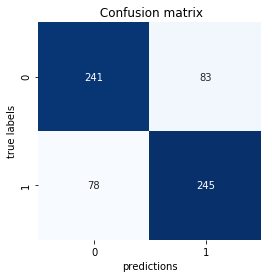

<Figure size 432x288 with 0 Axes>

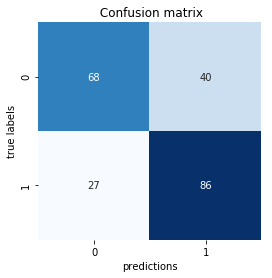

In [26]:
model = None
noise_training = False

n_channels = x_train.shape[1]
n_features = x_train.shape[2]
device = torch.device('cuda:0')
accuracy_epoch_scoring_val = EpochScoring(scoring='f1',name='f1_val',
                                          lower_is_better=False, on_train=False)
accuracy_epoch_scoring_train = EpochScoring(scoring='f1',name='f1_train',
                                            lower_is_better=False, on_train=True)
early_stopping = callbacks.EarlyStopping(monitor='valid_acc',
                                         patience=5,
                                         lower_is_better=False)
n_epochs = 200
kernel_size = n_features
padding_size = int(n_features/2)
model = NeuralNetClassifier(module=LeNet5, criterion=nn.CrossEntropyLoss,
                          module__n_channels= n_channels,
                          module__n_features=n_features,
                          module__C_k_p_s_1=[kernel_size,padding_size,2],
                          module__M_k_s_1=[2, 2],
                          module__M_k_s_2=[2, 2],
                          module__C_k_p_s_2=[kernel_size,padding_size,2],
                          module__p = [0.30357368,
                                       0.29148488, 
                                       0.00700351, 
                                       0.37788387, 
                                       0.19788962],
                          module__mid_layer_channels=39,
                          optimizer=optim.Adam, 
                          optimizer__lr=0.01,
                          #optimizer__weight_decay=0.01,
                          max_epochs=n_epochs, 
                          batch_size=100,
                          iterator_train__shuffle=True,
                          device=device,
                          warm_start=True,#train_split=None,
                          callbacks=[accuracy_epoch_scoring_val, 
                                     accuracy_epoch_scoring_train],
                         )
if noise_training:
    noise_rounds = 5
    for _ in range(noise_rounds):

        x_noise = add_noise(x_train)
        model.partial_fit(x_noise, y_train)
else:
    model.fit(x_train, y_train)
pred_test = model.predict(x_train)  # Predict labels of test data using the trained classifier
accuracy_of_net = plot_confusion_matrix(pred_test, y_train, prefix_information=model_name,
                          dataset_name='train', save_results=False,
                     y_pred_is_predicted_classes=True)

pred_test = model.predict(x_val)  # Predict labels of test data using the trained classifier
accuracy_of_net = plot_confusion_matrix(pred_test, y_val, prefix_information='LeNet',
                          dataset_name='', save_results=False,
                     y_pred_is_predicted_classes=True)



In [24]:
#model = pickle.load(open('models/yahoo_dataLenet-0.842_2019_05_16_01_44_12_FINAL.model', 'rb'))

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LeNet5. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Accuracy of Net: 0.82

Classification report:
             precision    recall  f1-score   support

          0       0.85      0.88      0.87       340
          1       0.76      0.72      0.74       182

avg / total       0.82      0.82      0.82       522

Accuracy of Net: 0.84

Classification report:
             precision    recall  f1-score   support

          0       0.87      0.88      0.88       113
          1       0.79      0.77      0.78        64

avg / total       0.84      0.84      0.84       177



<Figure size 432x288 with 0 Axes>

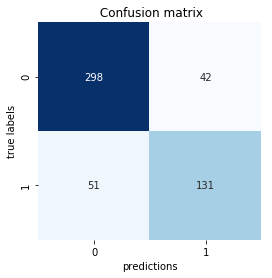

<Figure size 432x288 with 0 Axes>

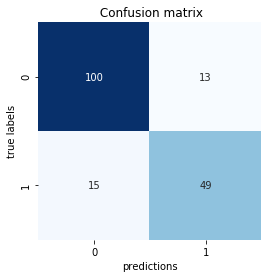

In [25]:
pred_test = model.predict(x_train)  # Predict labels of test data using the trained classifier
accuracy_of_net = plot_confusion_matrix(pred_test, y_train, prefix_information=model_name,
                          dataset_name='train', save_results=False,
                     y_pred_is_predicted_classes=True)
plt.savefig(fname='latex/figures/' + 'Lenet_Training_results' + '.pdf', format='pdf', dpi=300)

pred_test = model.predict(x_val)  # Predict labels of test data using the trained classifier
accuracy_of_net = plot_confusion_matrix(pred_test, y_val, prefix_information='RF',
                          dataset_name='', save_results=False,
                     y_pred_is_predicted_classes=True)

plt.savefig(fname='latex/figures/' + 'Lenet_Test_results' + '.pdf', format='pdf', dpi=300)

### Hyper Parameter Optimization

In [113]:
M = 10
optimizer__lr= np.random.uniform(1e-2, 1e-4, M)
weight_decay = np.random.uniform(1e-2,0.3 , M)
optimizer__weight_decay = np.random.uniform(1e-2,0.3 , M)
max_epochs = np.random.randint(2, 100, M)
mid_layer_channels = np.array(np.random.uniform(5, 64, M), dtype=int)
#batch_size = [4, 10, 20, 30]
optimizers = (optim.SGD, optim.Adam)
#C_k_p_s_1 = ([5, 0, 1],[4, 0, 1], [3, 0, 1], [2, 0, 1], [1, 0, 1])
C_k_p_s_1 = tuple([[np.random.randint(2, 5, size=1)[0],
                    np.random.randint(0, 4, size=1)[0], 
                    np.random.randint(1, 2, size=1)[0]]  for _ in range(M)])
C_k_p_s_2 = tuple([[np.random.randint(2, 5, size=1)[0],
                    np.random.randint(0, 4, size=1)[0], 
                    np.random.randint(1, 2, size=1)[0]]  for _ in range(M)])
p = [np.random.uniform(0.0, 0.5, size=5) for _ in range(M)]
p.append([0.1,0.1, 0.1, 0.1, 0.1])
p.append([0.0,0.0, 0.0, 0.0, 0.0])
p = tuple(p)
#C_k_p_s_1 = [5, 0, 1], M_k_s_1 = [2, 2], C_k_p_s_2 = [5, 0, 1], M_k_s_2 = [2, 2] 
# mid_layer_channels=16 p=[0.1,0.1, 0.1, 0.1, 0.1]
parameters = {#'optimizer__lr': optimizer__lr, 
    #'optimizer': optimizers, 
    #'optimizer__weight_decay': optimizer__weight_decay,
    #'module__C_k_p_s_1': C_k_p_s_1, 
    #'module__C_k_p_s_2': C_k_p_s_2,
    'module__mid_layer_channels': mid_layer_channels, 
    #'module__p': p, 
    #'max_epochs': max_epochs
}
print(parameters)

{'module__mid_layer_channels': array([49, 60, 29, 46, 13, 26, 48, 39, 33, 63])}


  epoch    f1_train    f1_val    train_loss    valid_acc    valid_loss     dur
-------  ----------  --------  ------------  -----------  ------------  ------
      1      0.5954    0.0000        0.7018       0.5455        0.6902  0.0210
      2      0.3797    0.4952        0.6810       0.5620        0.6692  0.0270
      3      0.5982    0.5234        0.6466       0.5785        0.6842  0.0205
      4      0.6198    0.5094        0.6418       0.5702        0.6687  0.0275
      5      0.6158    0.4694        0.6439       0.5702        0.6772  0.0248
      6      0.6040    0.5000        0.6398       0.5537        0.6734  0.0251


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7      0.6157    0.5000        0.6192       0.5702        0.6764  0.0277
      8      0.5946    0.4694        0.6365       0.5702        0.6767  0.0279
      9      0.5897    0.5321        0.6418       0.5785        0.6659  0.0269
     10      0.6115    0.4646        0.6223       0.5620        0.6790  0.0272
     11      0.5779    0.4583        0.6458       0.5702        0.6676  0.0267
     12      0.5836    0.4270        0.6246       0.5785        0.6717  0.0279
     13      0.5939    0.5000        0.6256       0.5868        0.6825  0.0265
     14      0.5954    0.4348        0.6366       0.5702        0.6704  0.0268
     15      0.5798    0.4600        0.6310       0.5537        0.6675  0.0268
     16      0.6313    0.4444        0.6302       0.5455        0.6853  0.0331
     17      0.6238    0.4956        0.6219       0.5289        0.6718  0.0213
     18      0.6187    0.4000        0.6149       0.6033        0.6732  0.0258
     19      0.5598    0.4717        0.6256       0.

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7      0.5105    0.5200        0.6673       0.6033        0.6479  0.0316
      8      0.5610    0.5490        0.6646       0.6198        0.6470  0.0309
      9      0.5581    0.4946        0.6565       0.6116        0.6544  0.0237
     10      0.5181    0.5200        0.6516       0.6033        0.6493  0.0293
     11      0.5375    0.5586        0.6554       0.5950        0.6396  0.0290
     12      0.6063    0.5347        0.6557       0.6116        0.6430  0.0350
     13      0.5590    0.5400        0.6472       0.6198        0.6403  0.0302
     14      0.5904    0.5893        0.6521       0.6198        0.6352  0.0207
     15      0.5707    0.5370        0.6523       0.5868        0.6417  0.0203
     16      0.6055    0.5333        0.6581       0.5950        0.6482  0.0183
     17      0.5735    0.5818        0.6591       0.6198        0.6393  0.0184
     18      0.5919    0.5607        0.6530       0.6116        0.6353  0.0182
     19      0.5972    0.5741        0.6406       0.

<Figure size 432x288 with 0 Axes>

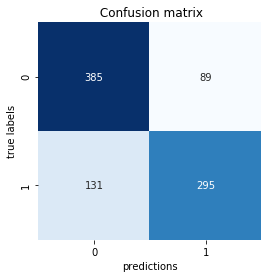

<Figure size 432x288 with 0 Axes>

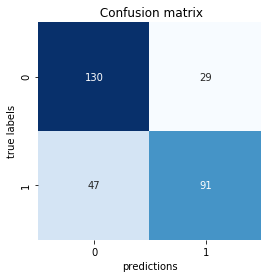

In [114]:
## net = None
rs = None
accuracy_epoch_scoring_val = EpochScoring(scoring='f1',
                                          name='f1_val',
                                          lower_is_better=False,
                                          on_train=False)
accuracy_epoch_scoring_train = EpochScoring(scoring='f1',
                                            name='f1_train', 
                                            lower_is_better=False, 
                                            on_train=True)
device = torch.device('cuda:0')
n_channels = x_train.shape[1]
n_features = x_train.shape[2]
n_epochs = 100
kernel_size = n_features
padding_size = int(n_features/2)
net = NeuralNetClassifier(module=LeNet5, criterion=nn.CrossEntropyLoss,
                          module__n_channels= n_channels,
                          module__n_features=n_features,
                          module__C_k_p_s_1=[kernel_size,padding_size,1],
                          module__M_k_s_1=[2, 2],
                          module__M_k_s_2=[2, 2],
                          module__C_k_p_s_2=[kernel_size,padding_size,1],
                          module__p = [0.30357368, 
                                       0.29148488, 
                                       0.00700351, 
                                       0.37788387, 
                                       0.19788962],
                          module__mid_layer_channels=39,
                          optimizer=optim.Adam, 
                          optimizer__lr = 0.01,
                          #optimizer__weight_decay=0.01,
                          max_epochs=n_epochs, 
                          batch_size=100,
                          iterator_train__shuffle=False,
                          device=device,
                          warm_start=True,#train_split=None,
                          callbacks=[accuracy_epoch_scoring_val, 
                                     accuracy_epoch_scoring_train],
                         )
model_name = LeNet5.__name__
rs = RandomizedSearchCV(net, parameters, refit=True, 
                        n_iter=5, n_jobs=1,
                       cv=3, scoring='accuracy')
#rs = GridSearchCV(net, parameters, n_jobs=1, refit=True, 
#                 scoring='f1', cv=3)
rs.fit(x_train, y_train)
model = rs.best_estimator_
pred_test = model.predict(x_train)  # Predict labels of test data using the trained classifier
accuracy_of_net = plot_confusion_matrix(pred_test, y_train, prefix_information=model_name,
                          dataset_name='train', save_results=False,
                     y_pred_is_predicted_classes=True)

pred_test = rs.predict(x_val)  # Predict labels of test data using the trained classifier
accuracy_of_net = plot_confusion_matrix(pred_test, y_val, prefix_information='RF',
                          dataset_name='', save_results=False,
                     y_pred_is_predicted_classes=True)

Accuracy of Net: 0.84

Classification report:
             precision    recall  f1-score   support

          0       0.88      0.88      0.88       340
          1       0.78      0.77      0.77       182

avg / total       0.84      0.84      0.84       522

Accuracy of Net: 0.83

Classification report:
             precision    recall  f1-score   support

          0       0.87      0.87      0.87       113
          1       0.77      0.77      0.77        64

avg / total       0.83      0.83      0.83       177



<Figure size 432x288 with 0 Axes>

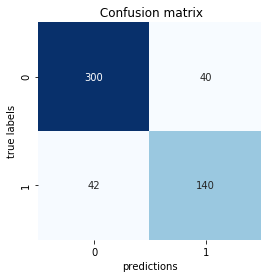

<Figure size 432x288 with 0 Axes>

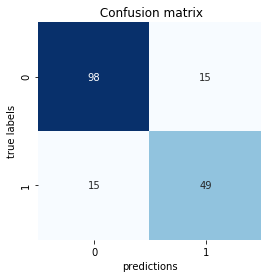

In [20]:
pred_test = model.predict(x_train)  # Predict labels of test data using the trained classifier
accuracy_of_net = plot_confusion_matrix(pred_test, 
                                        y_train,
                                        prefix_information=model_name,
                          dataset_name='train', save_results=False,
                     y_pred_is_predicted_classes=True)
plt.savefig(fname='latex/figures/' + 'AvgLenet_Training_results' + '.pdf',
            format='pdf', dpi=300)

pred_test = model.predict(x_val)  # Predict labels of test data using the trained classifier
accuracy_of_net = plot_confusion_matrix(pred_test, 
                                        y_val, 
                                        prefix_information='RF',
                          dataset_name='', save_results=False,
                     y_pred_is_predicted_classes=True)

plt.savefig(fname='latex/figures/' + 'AvgLenet_Test_results' + '.pdf',
            format='pdf', dpi=300)

In [115]:
rs.best_params_

{'module__mid_layer_channels': 39}

In [116]:
rs.grid_scores_

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.71556, std: 0.02347, params: {'module__mid_layer_channels': 48},
 mean: 0.73444, std: 0.00786, params: {'module__mid_layer_channels': 39},
 mean: 0.71333, std: 0.02373, params: {'module__mid_layer_channels': 63},
 mean: 0.73111, std: 0.00956, params: {'module__mid_layer_channels': 60},
 mean: 0.71333, std: 0.02625, params: {'module__mid_layer_channels': 29}]

In [17]:
model_dir_path = 'models'
model_filename = "{:s}/{}AvgLenet-{:2.3f}_{:s}_FINAL.model".format(
    model_dir_path, 'yahoo_data', accuracy_of_net, strftime("%Y_%m_%d_%H_%M_%S", localtime())
)
pickle.dump(model, open(model_filename, 'wb'))

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type AvgLeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
